What is the impact of a last dense layer on the encoder(s) on the previous two models?

In [2]:
import sys; sys.path.insert(0, '..')
import models
import dataset
from keras.models import Model
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from skimage.transform import resize

In [17]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = resize(x_train, (x_train.shape[0], 32, 32, 1))
x_test = resize(x_test, (x_test.shape[0], 32, 32, 1))

In [5]:
batch_size = 32
train_gen = dataset.BatchGenerator2(x_train, batch_size)
test_gen = dataset.BatchGenerator2(x_test, batch_size)

In [11]:
# model v1 with dense
input_shape = (16,16,1)
latent_dim = 4

# shared layers
conv1  = Conv2D(filters=32, kernel_size=(4,4), strides=(4,4), activation='relu', padding='valid', name='conv1')
conv2  = Conv2D(filters=64, kernel_size=(2,2), strides=(2,2), activation='relu', padding='valid', name='conv2')
pt_conv = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='sigmoid', padding='valid', name='pt_conv')
flat = Flatten()
dense1 = Dense(units=4) # insert dense here: different setup.

inputs = [Input(shape=input_shape) for _ in range(4)]
outputs = []
for i in range(4):
    enc_out = dense1(flat(pt_conv(conv2(conv1(inputs[i])))))
    outputs.append(enc_out)
latent = concatenate(outputs, name="concatenate")
# dense1 = Dense(units=16)(latent) # insert dense: this would be equivalent

# decoder
x = Dense(units=8*8*32, activation='relu', name='dense')(latent)
x = Reshape(target_shape=(8, 8, 32), name='reshape')(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
dec_out = Conv2DTranspose(filters=1, kernel_size=3, padding='same')(x)

model1 = Model(inputs, dec_out,)
model1.compile(loss='mse', optimizer='rmsprop')
print(model1.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 16, 16, 1)]  0                                            
____________________________________________________________________________________________

Epoch 1/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0293 - val_loss: 0.0248
Epoch 2/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0190 - val_loss: 0.0169
Epoch 3/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0163 - val_loss: 0.0147
Epoch 4/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0148 - val_loss: 0.0141
Epoch 5/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 6/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0133 - val_loss: 0.0125
Epoch 7/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 8/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0124 - val_loss: 0.0129
Epoch 9/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 10/20
1875/1875 [==============================] - 12s 7ms/step - l

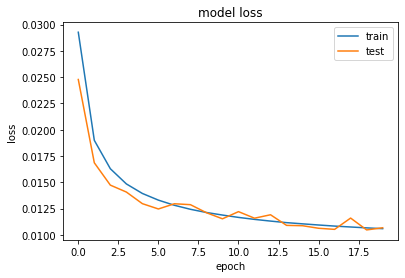

In [12]:
history = model1.fit(train_gen, validation_data=test_gen, epochs=20)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

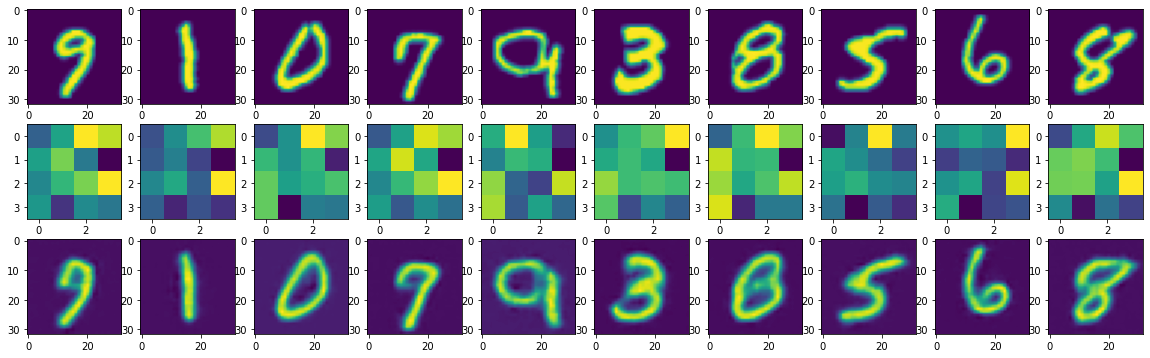

In [16]:
activation_model = tf.keras.models.Model(inputs=model1.input, outputs=[model1.get_layer('concatenate').output, model1.output])

plt.figure(figsize=(20, 6))
n = 10
for (xs,ys), i in zip(test_gen, range(n)):
    out1, out = activation_model.predict(xs)
    
    ax = plt.subplot(3, n, i+1)
    plt.imshow(ys[i].reshape(32,32))
    
    ax = plt.subplot(3, n, n+i+1)
    plt.imshow(out1[i].reshape(4,4))
    
    ax = plt.subplot(3, n, 2*n+i+1)
    plt.imshow(out[i].reshape(32,32))

In [19]:
# model v3 with dense
model2 = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(32,32,1), name='enc_in'),
        tf.keras.layers.Conv2D(filters=int(32), kernel_size=(4,4), strides=(4,4), activation='relu', padding='valid', use_bias=True, name='conv1'),
        tf.keras.layers.Conv2D(filters=int(64), kernel_size=(2,2), strides=(2,2), activation='relu', padding='valid', use_bias=True, name='conv2'),
        tf.keras.layers.Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), activation='sigmoid', padding='valid', name='pt_conv'),
        tf.keras.layers.Flatten(name='latent'),
        tf.keras.layers.Dense(units=16, name='enc_dense'), # new dense
        
        tf.keras.layers.Dense(units=8*8*32, activation='relu', name='dense'),
        tf.keras.layers.Reshape(target_shape=(8, 8, 32), name='reshape'),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='deconv1'),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='deconv2'),
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', name='dec_out')
    ]
)
model2.compile(loss='mse', optimizer='adam')
print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 8, 8, 32)          544       
_________________________________________________________________
conv2 (Conv2D)               (None, 4, 4, 64)          8256      
_________________________________________________________________
pt_conv (Conv2D)             (None, 4, 4, 1)           65        
_________________________________________________________________
latent (Flatten)             (None, 16)                0         
_________________________________________________________________
enc_dense (Dense)            (None, 16)                272       
_________________________________________________________________
dense (Dense)                (None, 2048)              34816     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 32)         

Epoch 1/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0259 - val_loss: 0.0170
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0157 - val_loss: 0.0144
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0140 - val_loss: 0.0135
Epoch 4/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0132 - val_loss: 0.0127
Epoch 5/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 7/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 8/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 9/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0115 - val_loss: 0.0114
Epoch 10/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.01

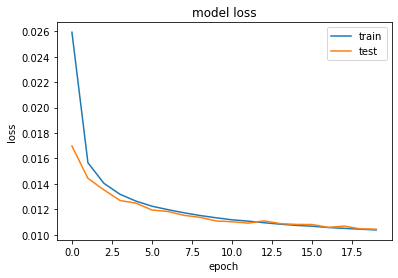

In [20]:
history = model2.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=20)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

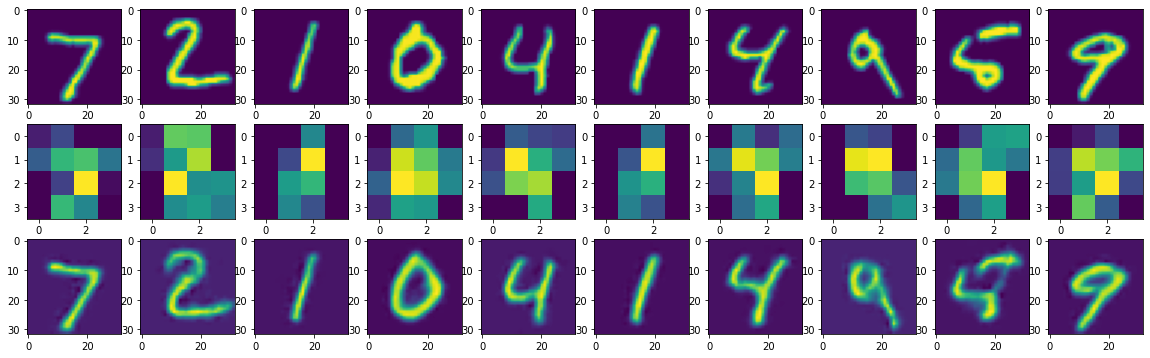

In [21]:
activation_model = tf.keras.models.Model(inputs=model2.input, outputs=[model2.get_layer('pt_conv').output, model2.output])

plt.figure(figsize=(20, 6))
n = 10
for i in range(n):
    out1, out = activation_model.predict(x_test[i].reshape(1,32,32,1))
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(32,32))
    
    ax = plt.subplot(3, n, n+i+1)
    plt.imshow(out1.reshape(4,4))
    
    ax = plt.subplot(3, n, 2*n+i+1)
    plt.imshow(out.reshape(32,32))